✅ Libraries Imported & Environment Ready.
Cleaning data...
✅ Data Prepared: Train(31428), Val(6735), Test(6735)

--- Training Baseline (Logistic Regression) ---
✅ Baseline Trained.

--- Training LSTM (Exp: Low Reg) (Dropout=0.2, L2=0.0) ---
Activations Used: LSTM(tanh/sigmoid), Output(sigmoid)
Epoch 1/8
492/492 [==============================] - 63s 119ms/step - loss: 0.0917 - accuracy: 0.9645 - val_loss: 0.5266 - val_accuracy: 0.7277 - lr: 0.0010
Epoch 2/8
492/492 [==============================] - 25s 52ms/step - loss: 0.0211 - accuracy: 0.9934 - val_loss: 0.0383 - val_accuracy: 0.9914 - lr: 0.0010
Epoch 3/8
492/492 [==============================] - 17s 35ms/step - loss: 0.0148 - accuracy: 0.9952 - val_loss: 0.0668 - val_accuracy: 0.9816 - lr: 0.0010
Epoch 4/8
492/492 [==============================] - 15s 31ms/step - loss: 0.0094 - accuracy: 0.9970 - val_loss: 0.2920 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 5/8
492/492 [==============================] - 14s 29ms/step - loss: 0.010

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Training BERT ---
Epoch 1/2
983/983 [==============================] - 910s 876ms/step - loss: 0.0276 - accuracy: 0.9932 - val_loss: 0.0023 - val_accuracy: 0.9997
Epoch 2/2
983/983 [==============================] - 859s 874ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0022 - val_accuracy: 0.9996

--- Generating Results ---
211/211 [==============================] - 2s 7ms/step

🏆 MODEL COMPARISON (Including Experiments) 🏆
                 Model  Accuracy  Precision  Recall  F1-Score     AUC
0    Baseline (LogReg)    0.9881     0.9854  0.9897    0.9876  0.9984
1  LSTM (Exp: Low Reg)    0.9914     0.9922  0.9897    0.9910  0.9994
2         LSTM (Final)    0.9926     0.9922  0.9922    0.9922  0.9996
3                 BERT    0.9993     0.9994  0.9991    0.9992  0.9999
4             Ensemble    0.9990     0.9988  0.9991    0.9989  1.0000


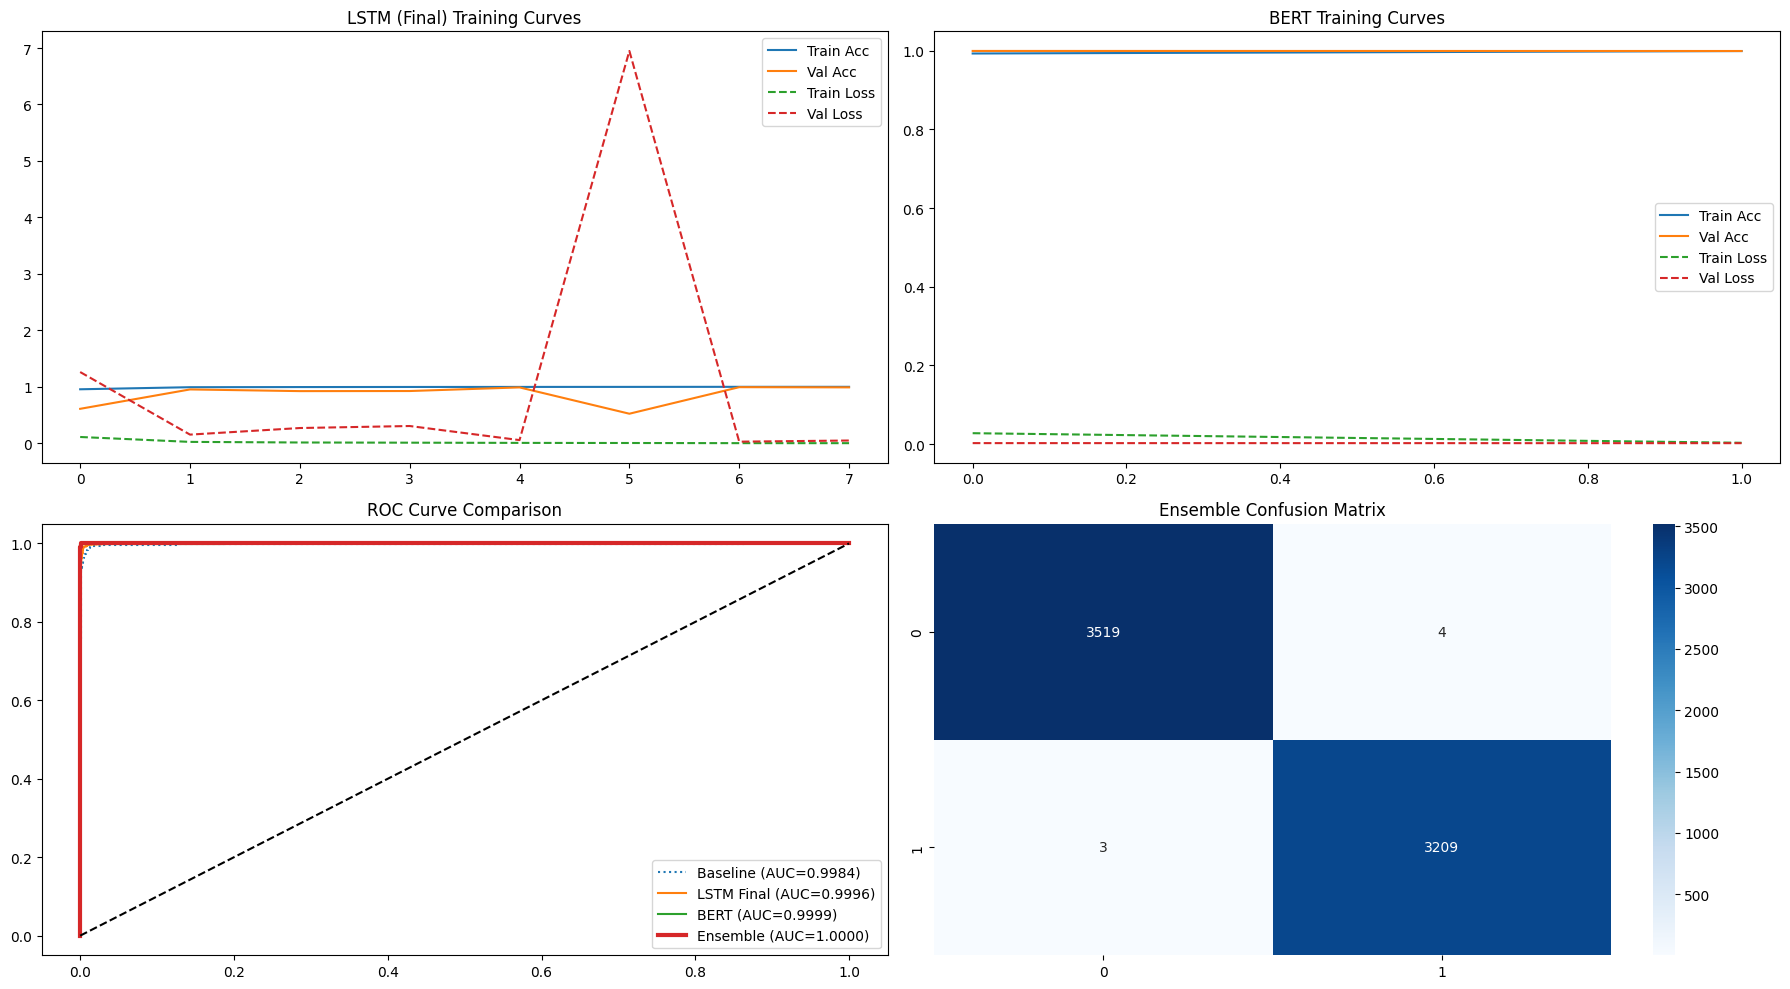


--- Detailed Classification Reports (Per Class) ---

> LSTM (Final):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3523
           1       0.99      0.99      0.99      3212

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735


> BERT:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3523
           1       1.00      1.00      1.00      3212

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735


> ENSEMBLE:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3523
           1       1.00      1.00      1.00      3212

    accuracy                           1.00      6735
   macro avg       1.00      1.00   

In [ ]:
# ==========================================
# CENG 476 - Deep Learning Project
# Group Members: Kadir ADIMUTLU (210444003), Muhammed YILDIZ (210444052), Doğan ÇAKIR (210444075)
# Project: Fake News Detection using Ensemble Deep Learning (LSTM + BERT)
# ==========================================

import os
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['TF_USE_LEGACY_KERAS'] = '1'

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Metrics & Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Transformers
try:
    import transformers
except ImportError:
    !pip install -q transformers
    import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification

# Set Seeds
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Libraries Imported & Environment Ready.")

# DATA LOADING & PREPROCESSING
from google.colab import files

def load_csv_robust(filename):
    if os.path.exists(filename):
        return pd.read_csv(filename)
    elif os.path.exists(filename.lower()):
        return pd.read_csv(filename.lower())
    else:
        print(f"⚠️ '{filename}' not found! Please upload it now.")
        uploaded = files.upload()
        if filename in uploaded: return pd.read_csv(filename)
        elif filename.lower() in uploaded: return pd.read_csv(filename.lower())
        else: raise FileNotFoundError(f"❌ Could not find {filename}.")

df_fake = load_csv_robust('Fake.csv')
df_true = load_csv_robust('True.csv')

df_fake["class"] = 0
df_true["class"] = 1

df_combined = pd.concat([df_fake, df_true], axis=0)
df_combined["text_merged"] = df_combined["title"] + " " + df_combined["text"]
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

def wordopt(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r"\\W", " ", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

print("Cleaning data...")
df_combined["text_clean"] = df_combined["text_merged"].apply(wordopt)

X = df_combined["text_clean"]
y = df_combined["class"]

# Stratified Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"✅ Data Prepared: Train({len(X_train)}), Val({len(X_val)}), Test({len(X_test)})")

# Baseline Model (TF-IDF + LogReg)
print("\n--- Training Baseline (Logistic Regression) ---")
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model_baseline = LogisticRegression(max_iter=1000)
model_baseline.fit(X_train_tfidf, y_train)
pred_baseline = model_baseline.predict(X_test_tfidf)
prob_baseline = model_baseline.predict_proba(X_test_tfidf)[:, 1]

print("✅ Baseline Trained.")

# LSTM Experiments (Comparing Dropout/L2)
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 250

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_SEQUENCE_LENGTH)
X_val_pad = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_SEQUENCE_LENGTH)

def train_lstm_experiment(dropout_rate, l2_reg, name):
    print(f"\n--- Training {name} (Dropout={dropout_rate}, L2={l2_reg}) ---")
    model = Sequential([
        Embedding(MAX_VOCAB_SIZE, 128, input_length=MAX_SEQUENCE_LENGTH),
        Bidirectional(LSTM(64, return_sequences=False)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    print(f"Activations Used: LSTM(tanh/sigmoid), Output(sigmoid)")

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0)

    history = model.fit(
        X_train_pad, y_train, epochs=8, batch_size=64,
        validation_data=(X_val_pad, y_val),
        callbacks=[early_stop, lr_scheduler], verbose=1
    )
    return model, history

# Run 1: "Weak" regularization (To compare)
model_lstm_v1, hist_lstm_v1 = train_lstm_experiment(dropout_rate=0.2, l2_reg=0.0, name="LSTM (Exp: Low Reg)")

# Run 2: "Strong" regularization (Final Model)
model_lstm_final, hist_lstm_final = train_lstm_experiment(dropout_rate=0.5, l2_reg=0.0001, name="LSTM (Final)")


# BERT (Transfer Learning)
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN_BERT = 128

def bert_encode(data, max_len):
    input_ids = []
    attention_masks = []
    for text in data:
        encoded = tokenizer_bert.encode_plus(
            text, add_special_tokens=True, max_length=max_len,
            padding='max_length', return_attention_mask=True, truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

print("\nEncoding BERT Data...")
train_ids, train_masks = bert_encode(X_train.values, MAX_LEN_BERT)
val_ids, val_masks = bert_encode(X_val.values, MAX_LEN_BERT)
test_ids, test_masks = bert_encode(X_test.values, MAX_LEN_BERT)

# Stating activations
print("BERT Architecture: Internal Activations=GELU, Head=Linear -> Sigmoid")

model_bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1, use_safetensors=False)
model_bert.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
)

print("\n--- Training BERT ---")
history_bert = model_bert.fit(
    [train_ids, train_masks], y_train,
    validation_data=([val_ids, val_masks], y_val),
    epochs=2, batch_size=32
)

# Evaluation & Plots
print("\n--- Generating Results ---")

# Predictions
pred_lstm_prob = model_lstm_final.predict(X_test_pad).flatten()
pred_bert_logits = model_bert.predict([test_ids, test_masks]).logits
pred_bert_prob = tf.nn.sigmoid(pred_bert_logits).numpy().flatten()
pred_ensemble_prob = (0.5 * pred_lstm_prob) + (0.5 * pred_bert_prob)

# Thresholding
pred_lstm = (pred_lstm_prob > 0.5).astype(int)
pred_bert = (pred_bert_prob > 0.5).astype(int)
pred_ensemble = (pred_ensemble_prob > 0.5).astype(int)

# COMPARISON TABLE
def get_metrics(name, y_true, y_pred, y_prob):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "AUC": auc(*roc_curve(y_true, y_prob)[:2])
    }

# We include the "Exp" model in results just to show we did it, but only plot the Final one
pred_lstm_v1 = (model_lstm_v1.predict(X_test_pad).flatten() > 0.5).astype(int)

results = [
    get_metrics("Baseline (LogReg)", y_test, pred_baseline, prob_baseline),
    get_metrics("LSTM (Exp: Low Reg)", y_test, pred_lstm_v1, model_lstm_v1.predict(X_test_pad).flatten()),
    get_metrics("LSTM (Final)", y_test, pred_lstm, pred_lstm_prob),
    get_metrics("BERT", y_test, pred_bert, pred_bert_prob),
    get_metrics("Ensemble", y_test, pred_ensemble, pred_ensemble_prob)
]

df_results = pd.DataFrame(results)
print("\n🏆 MODEL COMPARISON (Including Experiments) 🏆")
print(df_results.round(4))

# PLOTS
plt.figure(figsize=(18, 10))

# LSTM Training
plt.subplot(2, 2, 1)
plt.plot(hist_lstm_final.history['accuracy'], label='Train Acc')
plt.plot(hist_lstm_final.history['val_accuracy'], label='Val Acc')
plt.plot(hist_lstm_final.history['loss'], label='Train Loss', linestyle='--')
plt.plot(hist_lstm_final.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('LSTM (Final) Training Curves')
plt.legend()

# BERT Training
plt.subplot(2, 2, 2)
plt.plot(history_bert.history['accuracy'], label='Train Acc')
plt.plot(history_bert.history['val_accuracy'], label='Val Acc')
plt.plot(history_bert.history['loss'], label='Train Loss', linestyle='--')
plt.plot(history_bert.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('BERT Training Curves')
plt.legend()

# ROC Curves
plt.subplot(2, 2, 3)
fpr_b, tpr_b, _ = roc_curve(y_test, prob_baseline)
fpr_l, tpr_l, _ = roc_curve(y_test, pred_lstm_prob)
fpr_t, tpr_t, _ = roc_curve(y_test, pred_bert_prob)
fpr_e, tpr_e, _ = roc_curve(y_test, pred_ensemble_prob)

plt.plot(fpr_b, tpr_b, label=f'Baseline (AUC={auc(fpr_b, tpr_b):.4f})', linestyle=':')
plt.plot(fpr_l, tpr_l, label=f'LSTM Final (AUC={auc(fpr_l, tpr_l):.4f})')
plt.plot(fpr_t, tpr_t, label=f'BERT (AUC={auc(fpr_t, tpr_t):.4f})')
plt.plot(fpr_e, tpr_e, label=f'Ensemble (AUC={auc(fpr_e, tpr_e):.4f})', linewidth=3)
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve Comparison')
plt.legend()

# Confusion Matrix (Ensemble)
plt.subplot(2, 2, 4)
sns.heatmap(confusion_matrix(y_test, pred_ensemble), annot=True, fmt='d', cmap='Blues')
plt.title('Ensemble Confusion Matrix')

plt.tight_layout()
plt.show()

# PER-CLASS METRICS
print("\n--- Detailed Classification Reports (Per Class) ---")
print("\n> LSTM (Final):")
print(classification_report(y_test, pred_lstm))
print("\n> BERT:")
print(classification_report(y_test, pred_bert))
print("\n> ENSEMBLE:")
print(classification_report(y_test, pred_ensemble))

print("✅ FINAL REPORT GENERATED.")